# Technical Analysis with Pandas ([pandas_ta](https://github.com/twopirllc/pandas-ta))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas_ta as ta
from alphaVantageAPI.alphavantage import AlphaVantage  # pip install alphaVantage-api
e = pd.DataFrame()

### Help on Indicators (post an [issue](https://github.com/twopirllc/pandas-ta/issues) if the indicator doc needs updating)

In [2]:
e.ta.indicators()

pandas.ta - Technical Analysis Indicators
Total Indicators: 81
Abbreviations:
    accbands, ad, adosc, adx, ao, aobv, apo, aroon, atr, bbands, bop, cci, cmf, cmo, coppock, cross, decreasing, dema, donchian, dpo, efi, ema, eom, fwma, hl2, hlc3, hma, ichimoku, increasing, kc, kst, kurtosis, linreg, log_return, long_run, macd, mad, massi, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, percent_return, ppo, pvi, pvol, pvt, pwma, qstick, quantile, rma, roc, rsi, short_run, skew, sma, stdev, stoch, swma, t3, tema, trend_return, trima, trix, true_range, tsi, uo, variance, vortex, vp, vwap, vwma, willr, wma, zlma, zscore


In [36]:
# Individual Indicator help
help(ta.sma)

Help on function sma in module pandas_ta.overlap:

sma(close, length=None, offset=None, **kwargs)
    Simple Moving Average (SMA)
    
    The Simple Moving Average is the classic moving average that is the equally
    weighted average over n periods.
    
    Sources:
        https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/simple-moving-average-sma/
    
    Calculation:
        Default Inputs:
            length=10
        SMA = SUM(close, length) / length
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period.  Default: 10
        offset (int): How many periods to offset the result.  Default: 0
    
    Kwargs:
        adjust (bool): Default: True
        presma (bool, optional): If True, uses SMA for initial value.
        fillna (value, optional): pd.DataFrame.fillna(value)
        fill_method (value, optional): Type of fill method
    
    Returns:
        pd.Series: New feature generated.



### Load Daily SPY from [AlphaVantage](http://www.alphavantage.com) and clean it up a little

In [4]:
ticker = 'SPY'
AV = AlphaVantage(premium=False, clean=True, output_size='full')
df = AV.data(symbol=ticker, function='D') # Daily
df.name = ticker
df.set_index(['date'], inplace=True)
opendf = df['open']
closedf = df['close']
volumedf = df['volume']

In [5]:
last_ = df.shape[0]
# last_ = 100 # Uncomment for remaining subset
print(f"{df.name}{df.shape}")
df.head()

SPY(5369, 5)


,open,high,low,close,volume
date,,,,,
1998-01-02,97.3125,97.6562,96.5312,97.5625,2360900.0
1998-01-05,97.8437,98.4375,96.7812,97.7812,4191800.0
1998-01-06,97.2500,97.2812,96.1875,96.2187,3154900.0
1998-01-07,96.0937,96.7187,95.2187,96.4687,4424200.0
1998-01-08,96.3125,96.3125,95.3750,95.6250,3831000.0


In [6]:
volume = pd.DataFrame({'V+': volumedf[closedf > opendf], 'V-': volumedf[closedf < opendf]})

## Create some constants for some indicators

In [7]:
#help(df.ta.constants) # for more info
df.ta.constants(True, -4, 4)
df.tail()

,open,high,low,close,volume,-4,-3,-2,-1,0,1,2,3,4
date,,,,,,,,,,,,,,
2019-04-30,293.49,294.34,291.9200,294.0200,81111733.0,-4,-3,-2,-1,0,1,2,3,4
2019-05-01,294.72,294.95,291.8000,291.8100,71671870.0,-4,-3,-2,-1,0,1,2,3,4
2019-05-02,291.68,292.70,289.5200,291.1800,65030170.0,-4,-3,-2,-1,0,1,2,3,4
2019-05-03,292.82,294.34,291.2998,294.0300,56543653.0,-4,-3,-2,-1,0,1,2,3,4
2019-05-06,289.25,291.63,288.9300,291.5328,35015613.0,-4,-3,-2,-1,0,1,2,3,4


## Price & Volume Charts with Moving Averages

In [8]:
def machart(kind, fast, medium, slow, append=True, last=last_, figsize=(16,8), signal=None):
    ma1 = df.ta(kind=kind, length=fast, append=append)
    ma2 = df.ta(kind=kind, length=medium, append=append)
    ma3 = df.ta(kind=kind, length=slow, append=append)
    pricedf = df[['close', ma1.name, ma2.name, ma3.name]]
    title = f"{df.name}: {kind.upper()}s from {df.index[0]} to {df.index[-1]} ({last})"
    pricedf = df[['close', ma1.name, ma2.name, ma3.name]]
    pricedf.tail(last).plot(figsize=figsize, color=['black', 'green', 'orange', 'red'], title=title)

def volumechart(kind, length=10, last=last_, figsize=(16, 3)):
    title = f"{df.name} Volume: {kind.upper()} from {df.index[0]} to {df.index[-1]} ({last})"
    volume.tail(last).plot(kind='bar', figsize=figsize, width=0.5, color=['green', 'red'], alpha=0.45, stacked=True)
    df.ta(kind=kind, close=volumedf, length=length).tail(last).plot(figsize=figsize, linewidth=1.2, color='black', title=title)

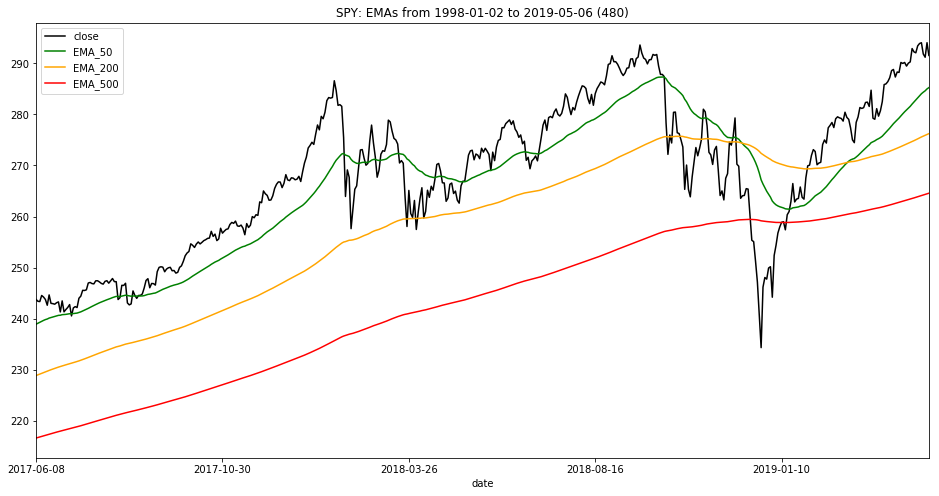

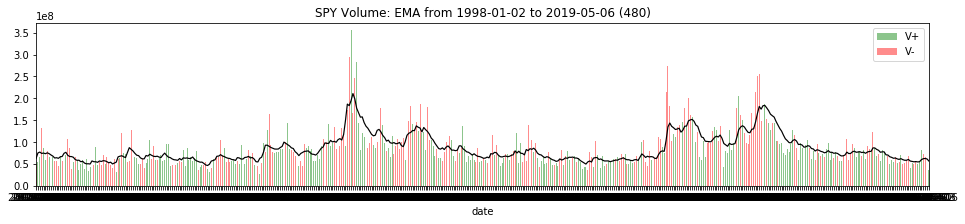

In [9]:
machart('ema', 50, 200, 500, last=480)
volumechart('ema', last=480)

## Indicator Examples
* Examples of simple and complex indicators.  Most indicators return a Series, while a few return DataFrames.
* All indicators can be called one of three ways. Either way, they return the result.

### Three ways to use pandas_ta
1. Stand Alone like TA-Lib  ta.**indicator**(*kwargs*).
2. As a DataFrame Extension like df.ta.**indicator**(*kwargs*).  Where df is a DataFrame with columns named 'open', 'high', 'low', 'close, 'volume' for simplicity.
3. Similar to #2, but by calling: df.ta(kind='**indicator**', *kwargs*).

### Cumulative Log Return

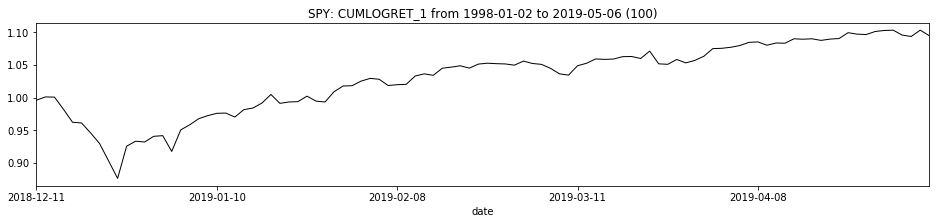

In [10]:
clr = df.ta.log_return(cumulative=True, append=True)
# df[['0', f"{clr.name}"]].tail(100).plot(figsize=(16, 3), color=['black'], linewidth=1, title=f"{df.name}: {clr.name} from {df.index[0]} to {df.index[-1]} ({last_})")
df[clr.name].tail(100).plot(figsize=(16, 3), color=['black'], linewidth=1, title=f"{df.name}: {clr.name} from {df.index[0]} to {df.index[-1]} (100)")

### MACD

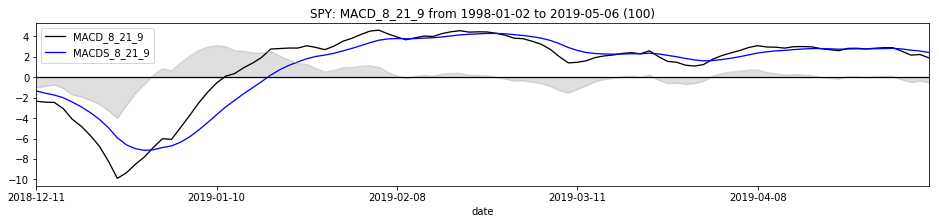

In [11]:
macddf = df.ta.macd(fast=8, slow=21, signal=9, min_periods=None, append=True)
macddf[[macddf.columns[0], macddf.columns[2]]].tail(100).plot(figsize=(16, 3), color=['black', 'blue'], linewidth=1.3)
macddf[macddf.columns[1]].tail(100).plot.area(figsize=(16, 3), stacked=False, color=['silver'], linewidth=1, title=f"{df.name}: {macddf.name} from {df.index[0]} to {df.index[-1]} (100)")
df['0'].tail(100).plot(figsize=(16, 3), color=['black'], linewidth=1.25)

### ZScore

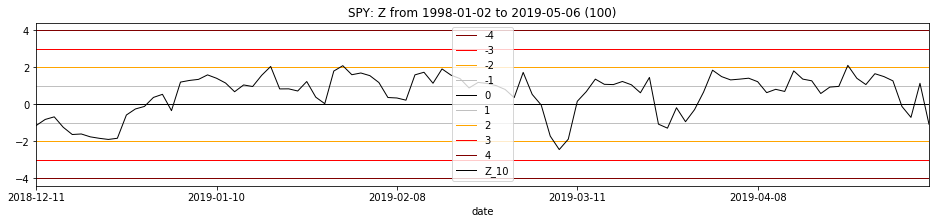

In [12]:
df.ta.zscore(length=10, append=True)
zcolors = ['maroon', 'red', 'orange', 'silver', 'black', 'silver', 'orange', 'red', 'maroon', 'black', 'blue']
zcols = df[['-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', 'Z_10']]
zcols.tail(100).plot(figsize=(16, 3), color=zcolors, linewidth=1, title=f"{df.name}: Z from {df.index[0]} to {df.index[-1]} (100)")

# New Features

### Archer On Balance Volume
Archer On Balance Volume (__aobv__) returns 

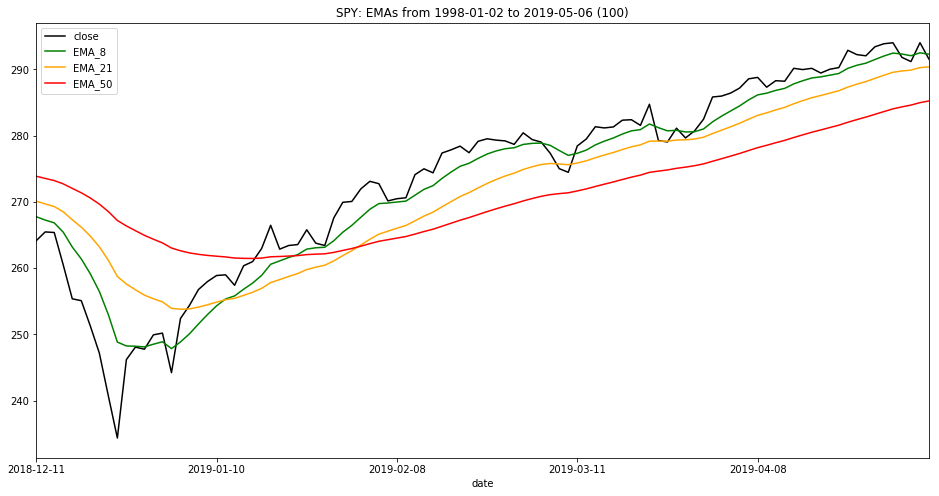

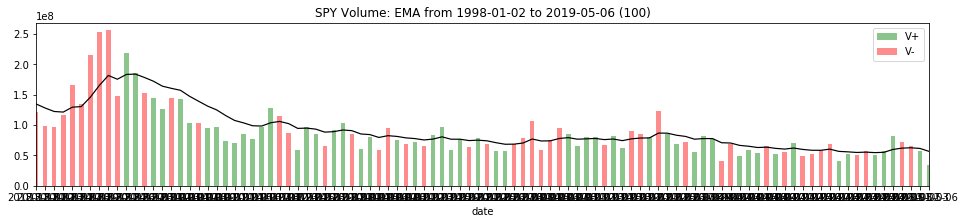

In [13]:
machart('ema', 8, 21, 50, last=100) # Price Chart so we can see the association with AOBV
volumechart('ema', last=100)

Columns[7]: OBV, OBV_min_2, OBV_max_2, OBV_EMA_10, OBV_EMA_30, AOBV_LR_2, AOBV_SR_2


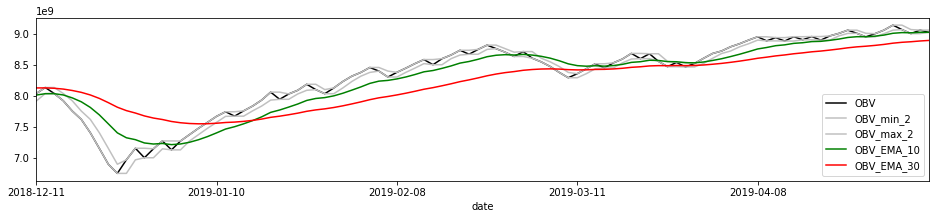

In [18]:
aobv = ta.aobv(close=closedf, volume=volumedf, mamode='ema', fast=10, slow=30)
aobv[aobv.columns[:5]].tail(100).plot(figsize=(16, 3), color=['black', 'silver', 'silver', 'green', 'red'])
print(f"Columns[{len(aobv.columns)}]: {', '.join(list(aobv.columns))}")

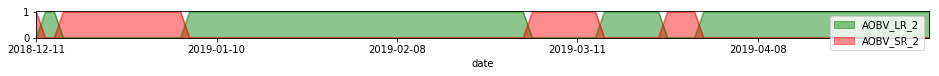

In [17]:
aobv[aobv.columns[-2:]].tail(100).plot(kind='area', figsize=(16, 0.5), color=['green', 'red'], alpha=0.45, stacked=False)

### Long Run and Short Run
Long Run (__long_run__) returns 1 if fast and slow averages approach each other from the below or both are increasing.  Otherwise returns 0.

Conversely, Short Run (__short_run__) returns 1 if fast and slow averages approach each other from above or both are decreasing.  Otherwise returns 0.

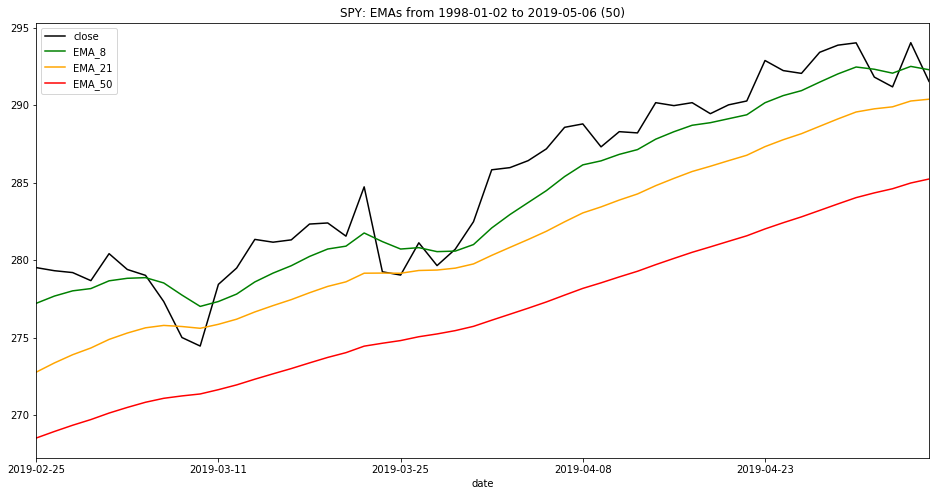

In [19]:
machart('ema', 8, 21, 50, last=50)

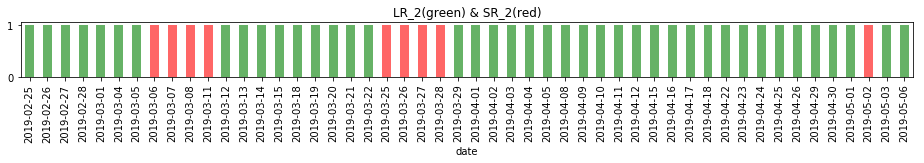

In [20]:
ema8 = df.ta.ema(length=8)
ema21 = df.ta.ema(length=21)
lrun = df.ta.long_run(ema8, ema21, append=False)
srun = df.ta.short_run(ema8, ema21, append=False)
srun.tail(50).plot(kind='bar', figsize=(16,1), color=['red'], linewidth=1, alpha=0.6)
lrun.tail(50).plot(kind='bar', figsize=(16,1), color=['green'], linewidth=1, alpha=0.6, title=f"{lrun.name}(green) & {srun.name}(red)")

### Cross
Cross (__cross__) returns 1 if two series cross and 0 if they do not.  By default, above=True.

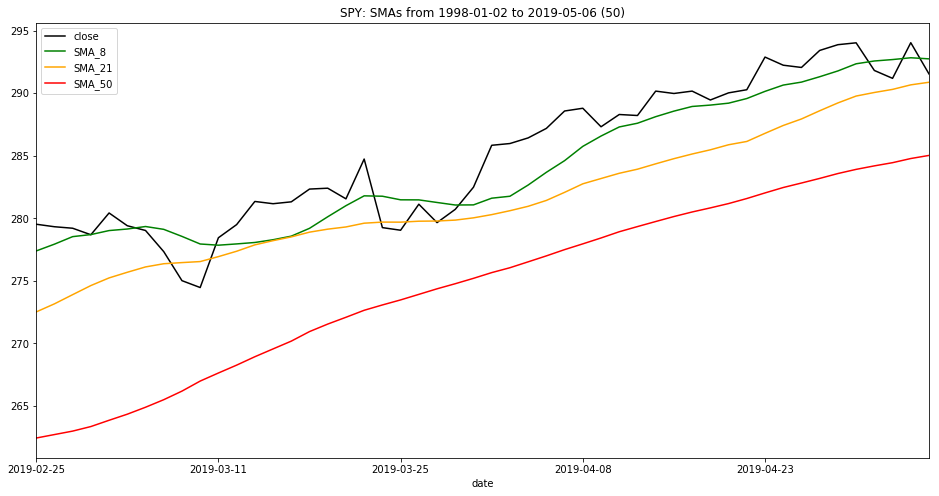

In [21]:
machart('sma', 8, 21, 50, last=50)

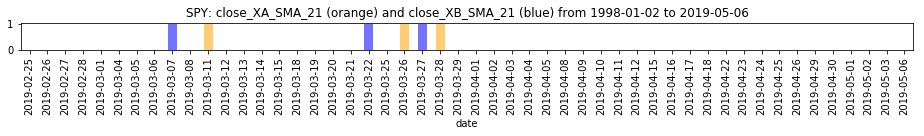

In [22]:
maf = df.ta(kind='sma', length=21)
cross_above = ta.cross(df['close'], maf, above=True)
cross_above.tail(50).plot(kind='bar', figsize=(16, 0.5), color=['orange'], linewidth=1, alpha=0.55, stacked=False)

cross_below = ta.cross(df['close'], maf, above=False)
cross_below.tail(50).plot(kind='bar', figsize=(16, 0.5), color=['blue'], linewidth=1, alpha=0.55, stacked=False, title=f"{df.name}: {cross_above.name} (orange) and {cross_below.name} (blue) from {df.index[0]} to {df.index[-1]}")

In [23]:
print(f"Most recent {cross_above.name} Dates:\n    {', '.join(list(cross_above[cross_above > 0].tail(6).index[::-1]))}")
print(f"Most recent {cross_below.name} Dates:\n    {', '.join(list(cross_below[cross_below > 0].tail(6).index[::-1]))}")

Most recent close_XA_SMA_21 Dates:
    2019-03-28, 2019-03-26, 2019-03-11, 2019-01-07, 2018-11-28, 2018-11-15
Most recent close_XB_SMA_21 Dates:
    2019-03-27, 2019-03-22, 2019-03-07, 2018-12-04, 2018-11-19, 2018-11-12


### Trend Return
* Trend Return (__trend_return__) calculates the cumulative log returns from a specified trend.
* There is no limit on how to construct a trend.  It can be as simple as: close > SMA(close, 50).

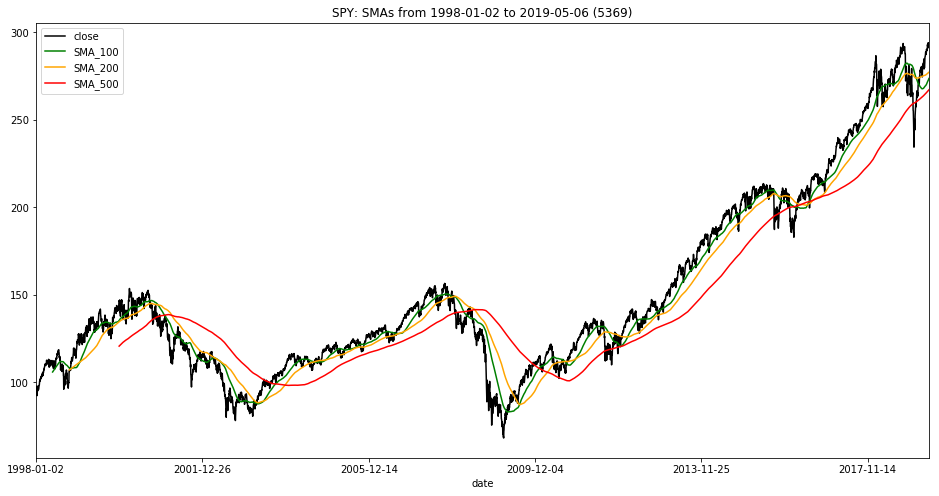

In [24]:
machart('sma', 100, 200, 500)#, last=50)

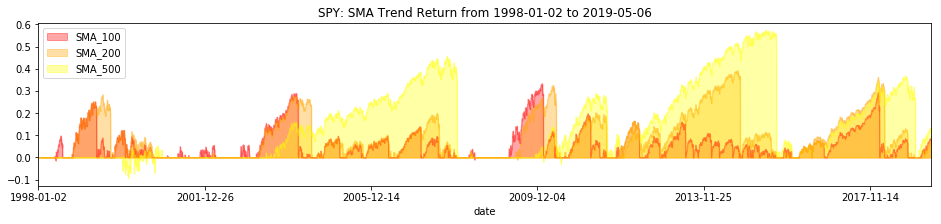

In [25]:
def ma_strategy(kind, fast, medium, slow, cumulative=True, variable=False, last=last_):
    """A very basic analysis of the closing price being greater than each moving average"""
    last = last if last is not None else df.shape[0]
    closedf = df['close']
    maf = df.ta(kind=kind, length=fast)
    mam = df.ta(kind=kind, length=medium)
    mas = df.ta(kind=kind, length=slow)
    tdf = pd.DataFrame({
        maf.name: ta.trend_return(closedf, closedf > maf, cumulative=cumulative, variable=variable),
        mam.name: ta.trend_return(closedf, closedf > mam, cumulative=cumulative, variable=variable),
        mas.name: ta.trend_return(closedf, closedf > mas, cumulative=cumulative, variable=variable),
    })
    tdf.set_index(closedf.index, inplace=True)
    window = tdf.tail(last)
    title = f"{df.name}: {kind.upper()} Trend Return from {window.index[0]} to {window.index[-1]}"
    window.plot.area(figsize=(16, 3), color=['red', 'orange', 'yellow'], linewidth=1, alpha=0.35, title=title, stacked=False)

ma_strategy('sma', 100, 200, 500)#, last=50)